2020s
==

In [400]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import h5netcdf
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [401]:
file_path_landfrac = r'C:\Users\jaybr\OneDrive\Desktop\UROP\sftlf_fx_CESM2-WACCM_G6sulfur_r1i1p1f2_gn.nc'
landfrac_dataset = xr.open_dataset(file_path_landfrac)
file_path_temp = r'C:\Users\jaybr\OneDrive\Desktop\UROP\tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc'
temperature_dataset = xr.open_dataset(file_path_temp)
file_path_pr = r'C:\Users\jaybr\OneDrive\Desktop\UROP\pr_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc'
pr_dataset = xr.open_dataset(file_path_pr)
file_path_area = r'C:\Users\jaybr\OneDrive\Desktop\UROP\areacella_fx_CESM2-WACCM_G6sulfur_r1i1p1f2_gn.nc'
area_dataset = xr.open_dataset(file_path_area)

C:\Users\jaybr\OneDrive\Anaconda\Lib\site-packages\xarray\conventions.py:428: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
C:\Users\jaybr\OneDrive\Anaconda\Lib\site-packages\xarray\conventions.py:428: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
C:\Users\jaybr\OneDrive\Anaconda\Lib\site-packages\xarray\conventions.py:428: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
C:\Users\jaybr\OneDrive\Anaconda\Lib\site-packages\xarray\conventions.py:428: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [402]:
area_masked = area_dataset.where(landfrac_dataset['sftlf'] > 50)

In [403]:
temperature_dataset_masked = temperature_dataset.where(landfrac_dataset['sftlf'] > 50)

In [404]:
start = '2090-01-01'
end = '2099-12-31'

tas = temperature_dataset_masked['tas'].sel(time=slice(start, end))

In [405]:
MAT = tas.mean(dim='time')

In [406]:
pr_dataset_masked = pr_dataset.where(landfrac_dataset['sftlf'] > 50) 

In [407]:
pr = pr_dataset_masked['pr'].sel(time=slice(start, end))

In [408]:
MAP = (pr*60*60*24*365.25).mean(dim='time')

In [409]:
pr_converted = (pr*60*60*24*365.25)

In [410]:
Tcold = temperature_dataset_masked['tas'].sel(time=slice(start, end)).groupby("time.month").mean().min(dim='month')

In [411]:
Thot = temperature_dataset_masked['tas'].sel(time=slice(start, end)).groupby("time.month").mean().max(dim='month')

C: Thot > 10 AND 0 < Tcold < 10

In [412]:
Thot_mask = Thot > 283.15
Tcold_mask = np.logical_and(Tcold > 273.15, Tcold < 291.15)

C = xr.where(np.logical_and(Tcold_mask, Thot_mask), True, False)

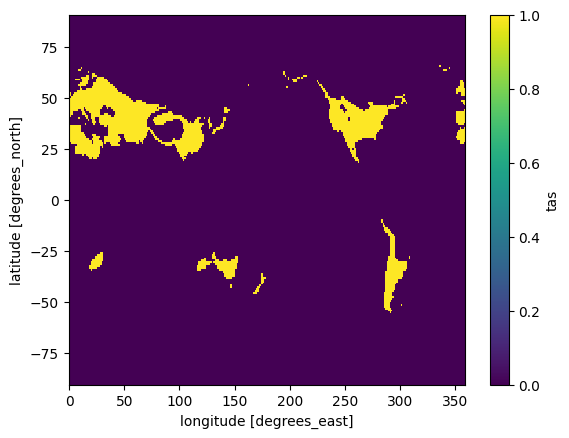

In [413]:
C.plot()

I think some arid conditions and (mostly) tropical areas are leaking into here, going to attempt to mask them out

In [414]:
file_path_B = r'D:\SSP5-8.5\ARID_dataset_2090s_SSP5_8.5.nc'
B_data = xr.open_dataset(file_path_B)
file_path_A = r'D:\SSP5-8.5\TROPICAL_dataset_2090s_SSP5_8.5.nc'
A_data = xr.open_dataset(file_path_A)

In [415]:
A = area_masked["areacella"]*A_data["A"]
B = area_masked['areacella']*B_data["B"]

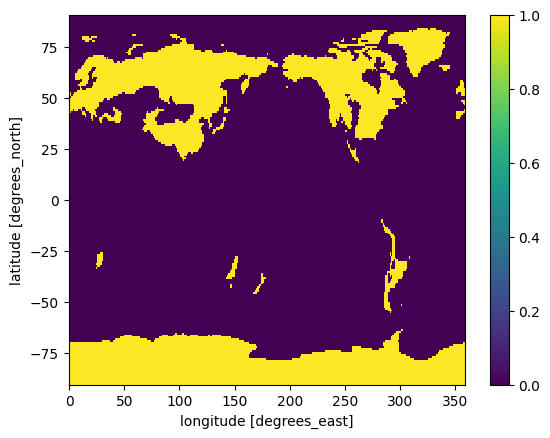

In [416]:
A_mask = xr.where(np.logical_not(A), True, False)
B_mask = xr.where(np.logical_not(B), True, False)
masked_conditions = xr.where(np.logical_and(B_mask, A_mask), True, False)
masked_conditions.plot()

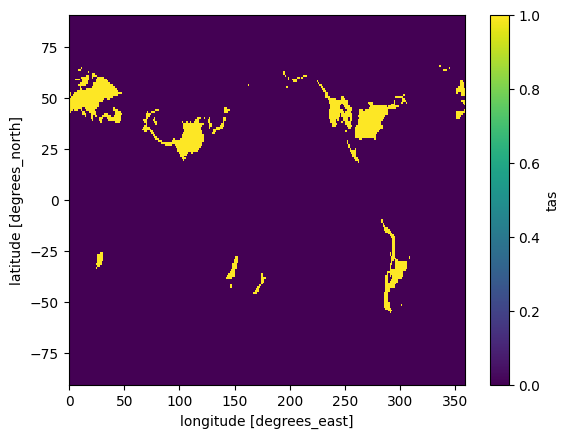

In [417]:
C_masked = xr.where(np.logical_and(C, masked_conditions), True, False)
C_masked.plot()

Now THIS looks correct 

Cs dry summer: Psdry < 40, Psdry < Pwwet/3 

In [418]:
pr_OM = (pr*60*60*24*365.25/2)[np.logical_or(pr.time.dt.month>=10, pr.time.dt.month<=3)].mean(dim='time')
pr_AS = (pr*60*60*24*365.25/2)[np.logical_and(pr.time.dt.month>=4, pr.time.dt.month<=9)].mean(dim='time')
tas_OM = (tas)[np.logical_or(tas.time.dt.month>=10, tas.time.dt.month<=3)].mean(dim='time')
tas_AS = (tas)[np.logical_and(tas.time.dt.month>=4, tas.time.dt.month<=9)].mean(dim='time')

In [419]:
P_winter = xr.where((tas_OM>tas_AS), pr_AS, pr_OM)
P_summer = xr.where((tas_OM>tas_AS), pr_OM, pr_AS)

In [420]:
Pdry =  pr_converted.sel(time=slice(start, end)).groupby("time.month").mean().min(dim='month')
#Pdry.plot()

Psdry = pr of the driest month in summer

Pdry = pr of the driest month, so need Pdry in summer specifically

In [421]:
NH_sum = pr_converted.sel(time=pr_converted['time.month'].isin([4,5,6,7,8,9]))

In [422]:
NH_sum_min = NH_sum.min(dim='time')
Psdry_NH = NH_sum_min.where(NH_sum_min['lat']>0)
#Psdry_NH.plot()

In [423]:
SH_sum = pr_converted.sel(time=pr_converted['time.month'].isin([10,11,12,1,2,3]))

In [424]:
SH_sum_min = SH_sum.min(dim='time')
Psdry_SH = SH_sum_min.where(SH_sum_min['lat'] < 0) 
#Psdry_SH.plot()

In [425]:
Psdry = Psdry_NH.combine_first(Psdry_SH)
#Pdry.plot()

this is the only way i can find Psdry.. i have absolutely no idea how to go about the seasons using the P_summer and P_winter variables instead of just manually putting in the numbers of months that should be summer/winter for both hemispheres

In [426]:
SH_wint = pr_converted.sel(time=pr_converted['time.month'].isin([4,5,6,7,8,9]))

In [427]:
NH_wint = pr_converted.sel(time=pr_converted['time.month'].isin([10, 11, 12, 1, 2, 3]))

In [428]:
SH_wint_min = SH_wint.min(dim='time')
Pwdry_SH = SH_wint_min.where(SH_wint_min['lat'] < 0) 
#Pwdry_SH.plot()

In [429]:
SH_wint_max = SH_wint.max(dim='time')
Pwwet_SH = SH_wint_max.where(SH_wint_max['lat'] < 0) 

In [430]:
NH_wint_min = NH_wint.min(dim='time')
Pwdry_NH = NH_wint_min.where(NH_wint_min['lat'] > 0) 
#Pwdry_NH.plot()

In [431]:
SH_wint_wet = SH_wint.max(dim='time')
Pwwet_SH = SH_wint_wet.where(SH_wint_wet['lat'] < 0) 
#Pwwet_SH.plot()

In [432]:
NH_wint_wet = NH_wint.max(dim='time')
Pwwet_NH = NH_wint_wet.where(NH_wint_wet['lat'] > 0) 
#Pwwet_SH.plot()

In [433]:
Pwdry = Pwdry_NH.combine_first(Pwdry_SH)
#Pwdry.plot()

In [434]:
Pwwet = Pwwet_SH.combine_first(Pwwet_NH)

In [435]:
criteria_1 = (Psdry < 40)
criteria_2 = (Psdry < (Pwwet/3))
Cs_criteria = xr.where(np.logical_and(criteria_1, criteria_2), True, False)

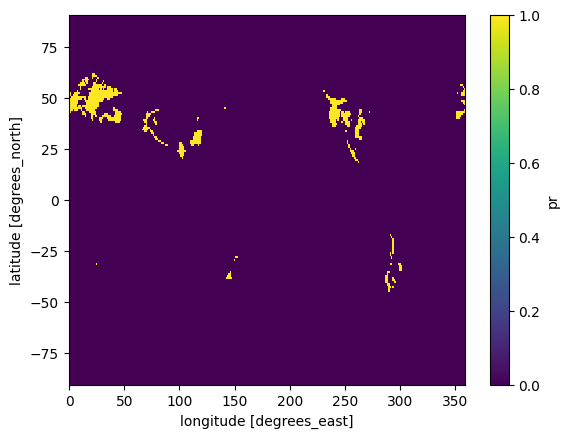

In [436]:
Cs = xr.where(np.logical_and(Cs_criteria, C_masked), True, False)
Cs.plot()

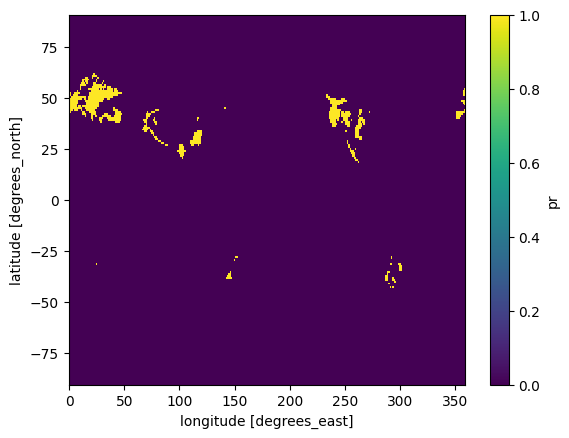

In [437]:
Csa = xr.where(np.logical_and(Cs, (Thot>=(273.15+22))), True, False)
Csa.plot()

Tmon10 = number of months where the mean temperature is above 10 C (283.15 K)

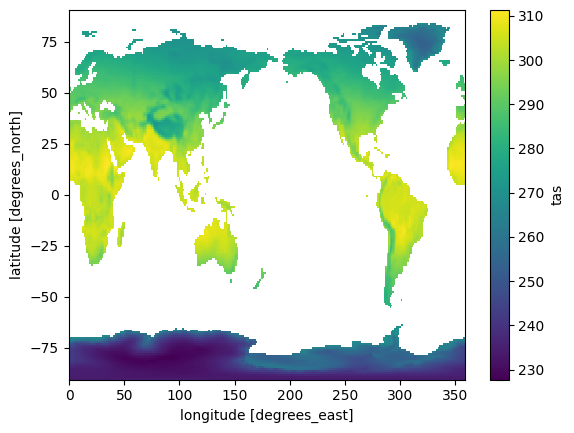

In [438]:
MAT.plot()

In [439]:
MAT.max().values

array(311.31723022)

pretty sure this is showing how many months are above 283 K per region? 

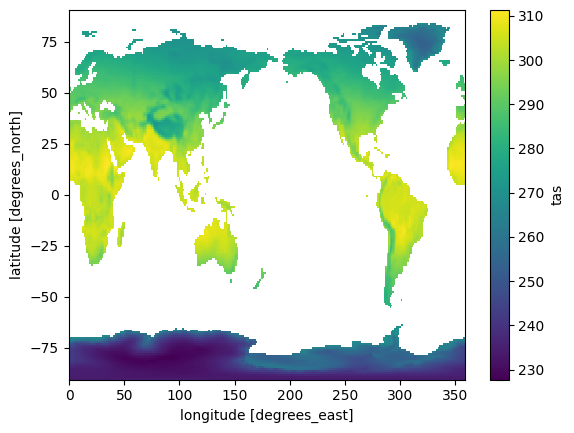

In [440]:
MAT.plot()

In [441]:
monthly_temp = temperature_dataset_masked['tas'].groupby("time.month").mean(dim="time")

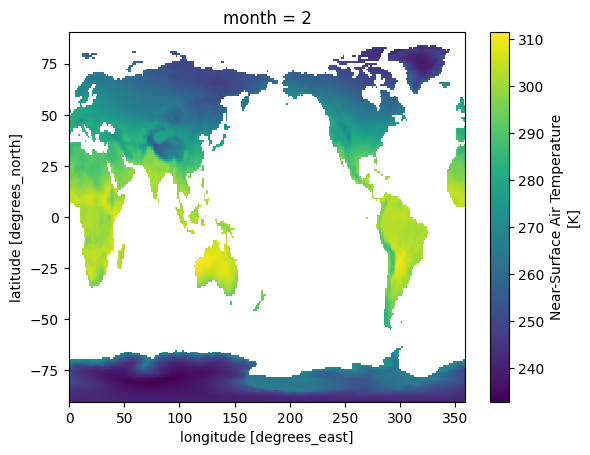

In [442]:
monthly_temp[1].plot()

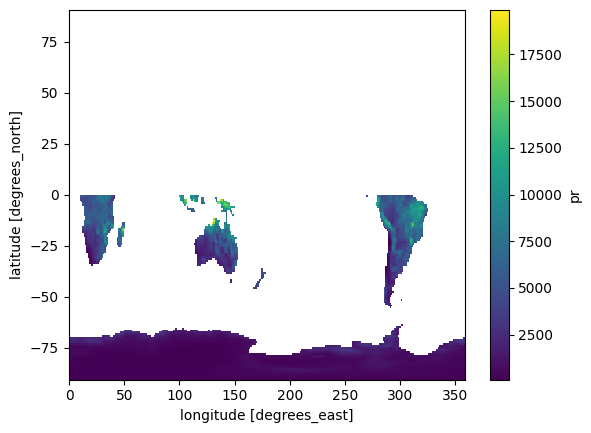

In [443]:
SH_sum_max = SH_sum.max(dim='time')
Pswet_SH = SH_sum_max.where(SH_sum_max['lat'] < 0) 
Pswet_SH.plot()

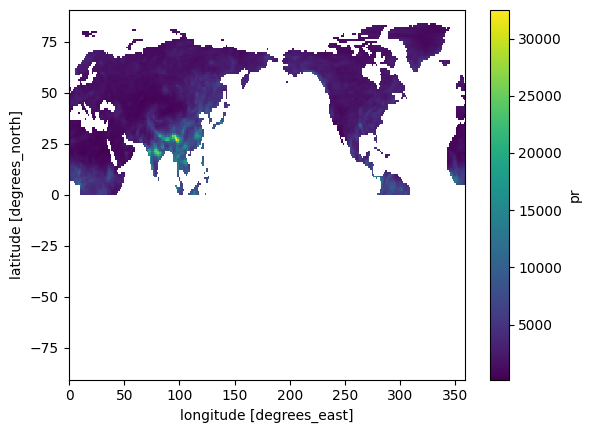

In [444]:
NH_sum_max = NH_sum.max(dim='time')
Pswet_NH = NH_sum_max.where(NH_sum_max['lat'] > 0) 
Pswet_NH.plot()

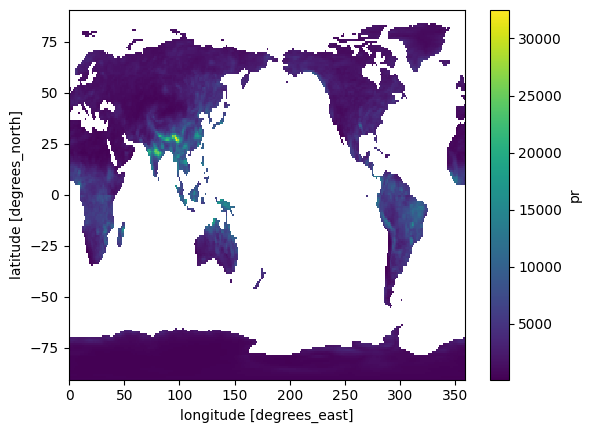

In [445]:
Pswet = Pswet_NH.combine_first(Pswet_SH)
Pswet.plot()

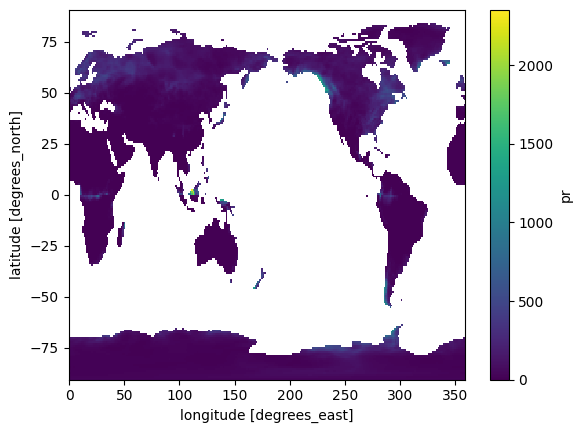

In [446]:
Pwdry.plot()

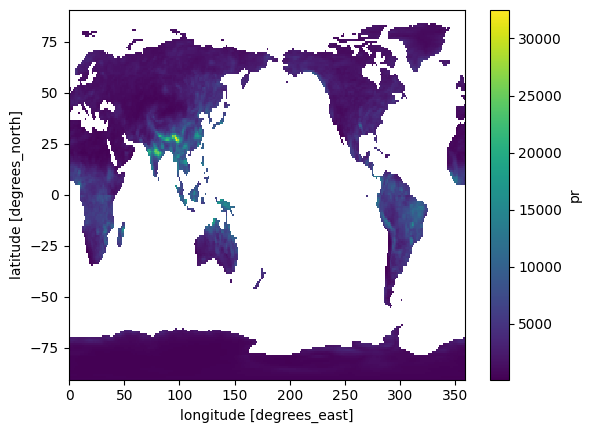

In [447]:
Pswet.plot()

In [448]:
tas_monthly = tas.groupby('time.month').mean()

In [449]:
tas_283 = xr.where((tas_monthly > 283.15), True, False)
Tmon10 = tas_283.sum(dim='month')

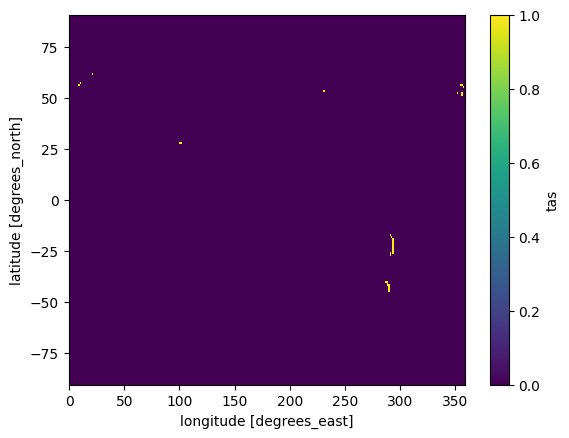

In [450]:
crit_b = Tmon10 >= 4
#s_crit_1 = Psdry < 40
#s_crit_2 = (Psdry < (Pwwet/3))
#s = xr.where(np.logical_and(s_crit_1, s_crit_2), True, False)
#b = xr.where(np.logical_and(s, C_masked), True, False)
#Csb_1 = xr.where(np.logical_and((~Csa), b), True, False)
#Csb = xr.where(np.logical_and(Csb_1, crit_b), True, False)
Csb_1 = xr.where(np.logical_and(crit_b, Cs), True, False)
Csb = xr.where(np.logical_and((Thot<(273.15+22)), Csb_1), True, False)
Csb.plot()

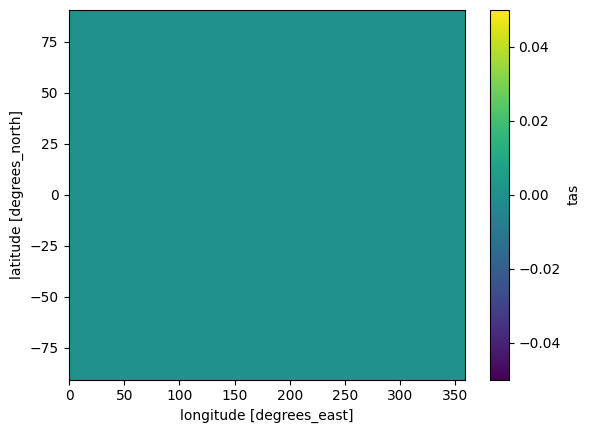

In [451]:
not_a_b = xr.where(np.logical_and((Thot<(273.15+22)), (Tmon10<4)), True, False)
#c_crit_1 = 1 <= Tmon10
#c_crit_2 = Tmon10 < 4
#c = xr.where(np.logical_and(c_crit_1, c_crit_2), True, False)
#c_2 = xr.where(np.logical_and(c, not_a_b), True, False)
#Csc = xr.where(np.logical_and(C_masked, c_2), True, False)
Csc_1 = xr.where(np.logical_and(not_a_b, Cs), True, False)
Csc = xr.where(np.logical_and(Csc_1, (Tmon10>=1)), True, False)
Csc.plot()

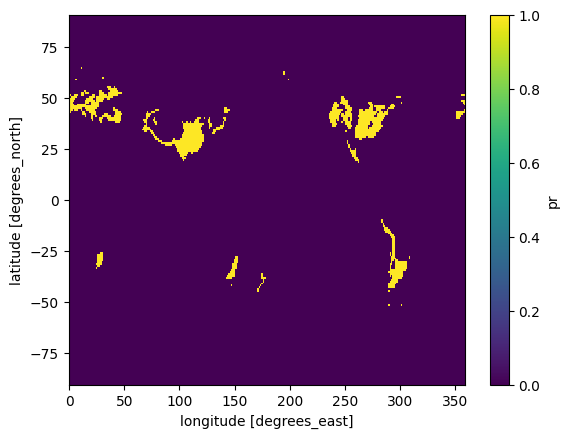

In [452]:
w_crit = (Pwdry < (Pswet/10))
Cw = xr.where(np.logical_and(w_crit, C_masked), True, False)
#not_Cs = xr.where(np.logical_not(Cs), True, False)
#Cw_1 = xr.where(np.logical_and(not_Cs, C_masked), True, False)
Cw.plot()

really similar to C_masked, but there are slight differences

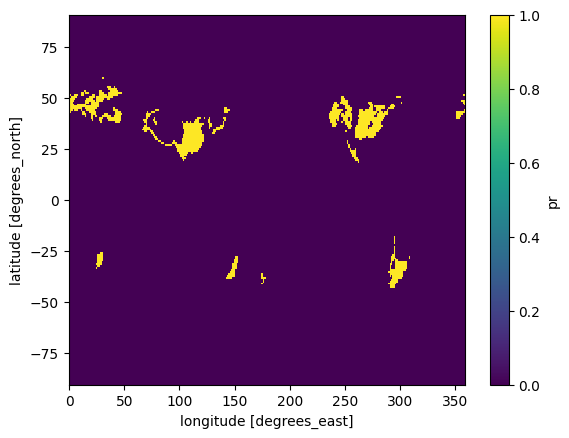

In [453]:
Cwa = xr.where(np.logical_and(Cw, (Thot>=(273.15+22))), True, False)
Cwa.plot()

C = C_masked, w = Pwdry<Pwwet/10, b = Tmon10>=4, not a = Thot < (273.15+22)

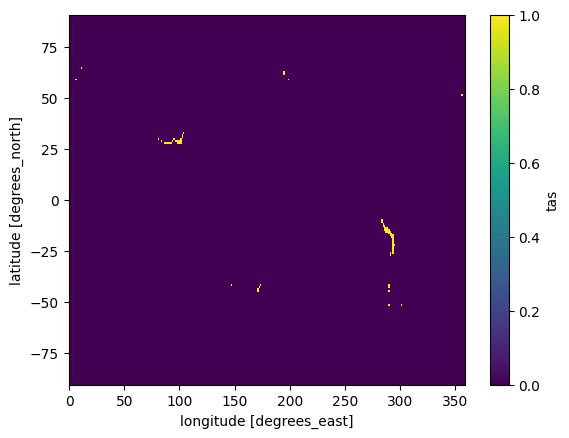

In [454]:
not_a = (Thot < (273.15+22))
b = Tmon10>=4
#w = (Pwdry<(Pwwet/10))
Cwb_1 = xr.where(np.logical_and(not_a, b), True, False)
#Cwb_2 = xr.where(np.logical_and(Cwb_1, w), True, False)
#Cwb_3 = xr.where(np.logical_and(Cwb_2, C_masked), True, False)
#Cwb = xr.where(np.logical_and(Cwb_3, Cw), True, False)
Cwb = xr.where(np.logical_and(Cwb_1, Cw), True, False)
Cwb.plot()

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

contour_levels = np.linspace(0, 5, 10)  
contour_plot = Cwb.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=contour_levels, add_colorbar=True)

ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

ax.set_title('G6sulfur Arid (B) Regions (2020-2029)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

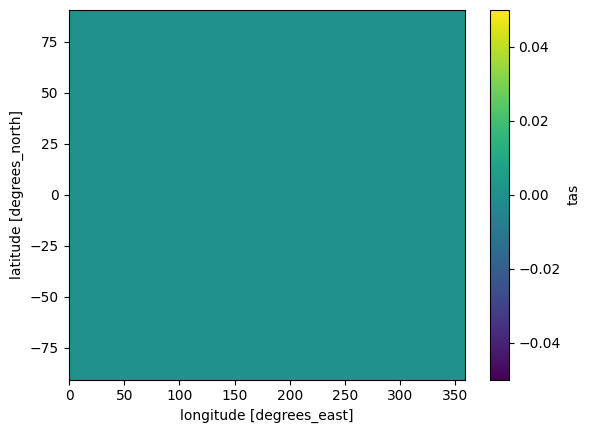

In [455]:
#Cwc_1 = xr.where(np.logical_and((~Cwa), (~Cwb)), True, False)
not_a_b = xr.where(np.logical_and(not_a, (Tmon10<4)), True, False)
Cwc_1 = xr.where(np.logical_and(not_a_b, (Tmon10>=1)), True, False)
Cwc_2 = xr.where(np.logical_and(Cwc_1, (Pwdry<(Pswet/10))), True, False)
Cwc = xr.where(np.logical_and(Cwc_2, C_masked), True, False)
#Cwc_2 = xr.where(np.logical_and((1<=Tmon10), (Tmon10<4)), True, False)
#Cwc_3 = xr.where(np.logical_and(Cwc_1, Cwc_2), True, False)
#Cwc_4 = xr.where(np.logical_and(C_masked, Cwc_3), True, False)
#Cwc = xr.where(np.logical_and(Cwc_4, Cw), True, False)
Cwc.plot()

Cf = not Cs or Cw

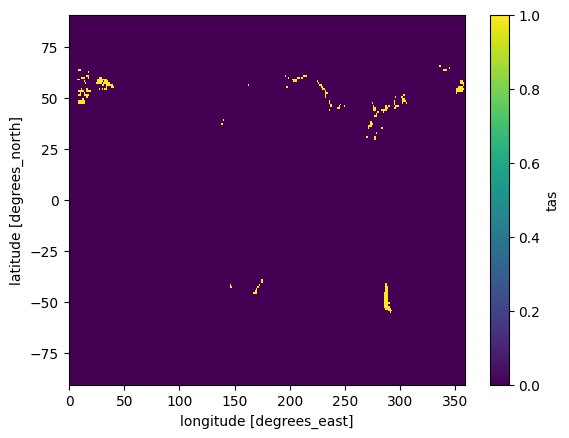

In [456]:
Cf_1 = xr.where(np.logical_and((~Cs), (~Cw)), True, False)
Cf = xr.where(np.logical_and(C_masked, Cf_1), True, False)
Cf.plot()

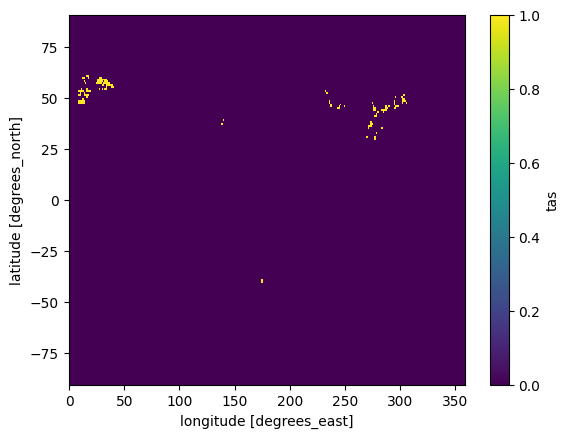

In [457]:
a = (Thot >= (273.15+22))
Cfa = xr.where(np.logical_and(a, Cf), True, False)
Cfa.plot()

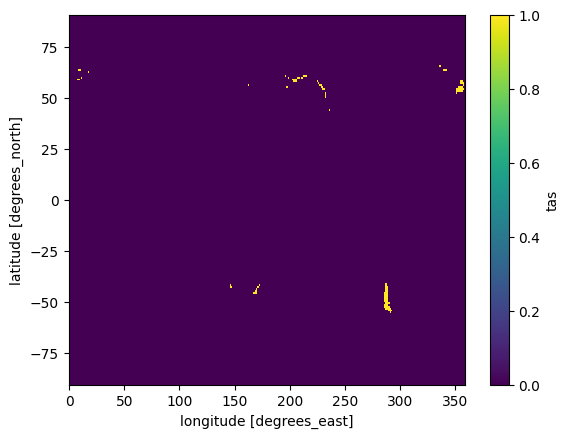

In [458]:
Cfb_1 = xr.where(np.logical_and(Cf, (Thot<(273.15+22))), True, False)
Cfb = xr.where(np.logical_and(Cfb_1, (Tmon10>=4)), True, False)
Cfb.plot()

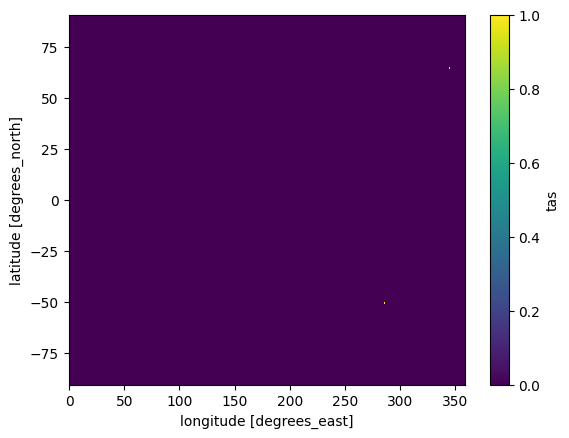

In [459]:
Cfc_1 = xr.where(np.logical_and(Cfb_1, (Tmon10>=1)), True, False)
Cfc = xr.where(np.logical_and(Cfc_1, (Tmon10<4)), True, False)
Cfc.plot()

In [460]:
C_set = xr.Dataset()

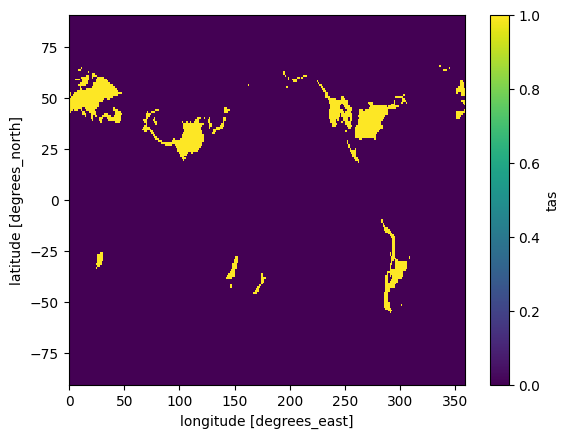

In [461]:
C_masked.plot()

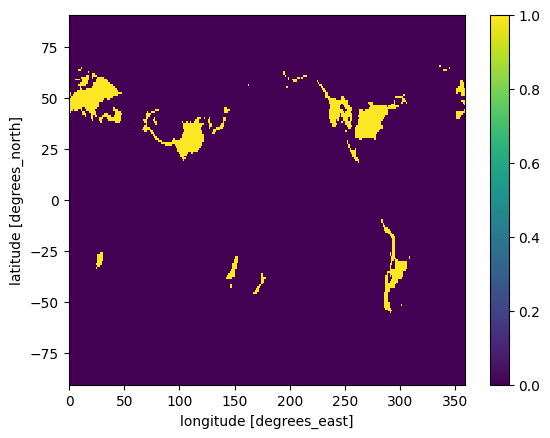

In [462]:
(Cs + Cw + Cf).plot()

In [463]:
C_set['lat'] = C_masked.lat
C_set['lon'] = C_masked.lon

In [464]:
C_set['C'] = C_masked
C_set['C'].attrs= {'long_name' : 'temperate'}

In [465]:
C_set['Cs'] = Cs
C_set['Cs'].attrs= {'long_name' : 'dry summer'}

In [466]:
C_set['Cw'] = Cw
C_set['Cw'].attrs= {'long_name' : 'dry winter'}

In [467]:
C_set['Cf'] = Cf
C_set['Cf'].attrs= {'long_name' : 'without dry season'}

In [468]:
C_set['Csa'] = Csa
C_set['Csa'].attrs= {'long_name' : 'dry, hot summer'}

In [469]:
C_set['Csb'] = Csb
C_set['Csb'].attrs= {'long_name' : 'dry, warm summer'}

In [470]:
C_set['Csc'] = Csc
C_set['Csc'].attrs= {'long_name' : 'dry, cold summer'}

In [471]:
C_set['Cwa'] = Cwa
C_set['Cwa'].attrs= {'long_name' : 'dry winter, hot summer'}

In [472]:
C_set['Cwb'] = Cwb
C_set['Cwb'].attrs= {'long_name' : 'dry winter, warm summer'}

In [473]:
C_set['Cwc'] = Cwc
C_set['Cwc'].attrs= {'long_name' : 'dry winter, cold summer'}

In [474]:
C_set['Cfa'] = Cfa
C_set['Cfa'].attrs= {'long_name' : 'without dry season, hot summer'}

In [475]:
C_set['Cfb'] = Cfb
C_set['Cfb'].attrs= {'long_name' : 'without dry season, warm summer'}

In [476]:
C_set['Cfc'] = Cfc
C_set['Cfc'].attrs= {'long_name' : 'without dry season, cold summer'}

In [477]:
C_set

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables: (12/13)
    C        (lat, lon) bool False False False False ... False False False False
    Cs       (lat, lon) bool False False False False ... False False False False
    Cw       (lat, lon) bool False False False False ... False False False False
    Cf       (lat, lon) bool False False False False ... False False False False
    Csa      (lat, lon) bool False False False False ... False False False False
    Csb      (lat, lon) bool False False False False ... False False False False
    ...       ...
    Cwa      (lat, lon) bool False False False False ... False False False False
    Cwb      (lat, lon) bool False False False False ... False False False False
    Cwc      (lat, lon) bool False False False False ... False False False False
    Cfa      (lat, lon) bool False False False False ... False False False False
    Cfb      (lat, lon) bool False False False False ... False False False False
    Cfc      (lat, lon) bool False False False False ... False False False False

In [478]:
C_set.to_netcdf(path='/Users/jaybr/OneDrive/Desktop/UROP/TEMP_dataset_2090s_SSP5_8.5.nc', mode='w')